# Mi loco estamos crazy
## real


In [8]:
import mne
import numpy as np
import os
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay

In [9]:
def trim_leading_zeros(raw, threshold=1):
    """Trim leading samples where all EEG channels are zero or flat."""
    data, times = raw.get_data(picks='eeg', return_times=True)

    signal_magnitude = np.abs(data).sum(axis=0)
    first_valid = np.argmax(signal_magnitude > threshold)

    raw.crop(tmin=times[first_valid])
    return raw

def open_bdf(path):
    raw = mne.io.read_raw_bdf(
        path,
        preload=True,
        stim_channel="Status"
    )
    mapping = {
    "EEG 1": "Fz",
    "EEG 2": "C3",
    "EEG 3": "Cz",
    "EEG 4": "C4",
    "EEG 5": "Pz",
    "EEG 6": "PO7",
    "EEG 7": "Oz",
    "EEG 8": "PO8"
    }

    raw.rename_channels(mapping)
    raw.drop_channels(['ACC X', 'ACC Y', 'ACC Z', 'GYR X', 'GYR Y', 'GYR Z', 'BAT', 'CNT', 'VALID', 'DT'])

    raw = trim_leading_zeros(raw)
    
    return raw

In [10]:
#aqui estamos solo quedandonos con las ventanas en las que el 90% o más es la misma respuesta, las demás las descartamos...
def purity(seg):
        c = np.bincount(seg, minlength=3)
        return c.max()/c.sum()  #nos da el porentaje
    
def concatenate_ventanado_etiquetado(fdata):
    raw = mne.concatenate_raws([open_bdf(dir_name + f) for f in fdata])

    print("Extrayendo eventos...")
    events = mne.find_events(raw, stim_channel="Status")
    print("IDs únicos:", np.unique(events[:, 2], return_counts=True))

    sfreq = raw.info["sfreq"]
    n_times = raw.n_times  #todas las muestras del registro

    TASK_DUR = 1.5
    task_samp = int(round(TASK_DUR * sfreq))

    y_t = np.zeros(n_times, dtype=np.int16)  # 0 reposo lo establecemos como predeterminado
    for samp, _, code in events:
        start = int(samp)
        end = min(start + task_samp, n_times)
        y_t[start:end] = int(code)  # 1 o 2

    print("Estados (0/1/2) en todo el registro:", np.unique(y_t, return_counts=True))


# Ahora solo EEG (el print es para ver los canales que se recnocen como eeg, que son 18, al filtrar por nombre solo nos quedamos con los electrodos)

#for name, typ in zip(raw.ch_names, raw.get_channel_types()):
#    print(f"{name:>12}  {typ}")

#el filtro de los primeros 8


#eeg_channels = [f"EEG {i}" for i in range(1, 9)]
#raw.pick(eeg_channels)

#ventanas + etiquetas por ventana. Lo que hacee es dividir las ventanas en instantes (en 250Hz) 
    raw_f = raw.copy().filter(8., 30., verbose=False)

    sfreq = raw_f.info["sfreq"]
    win_sec = 1.5    #tiempo de cada ventana
    step_sec = 0.25  #timepo entre ventanas (se solapan, no se si dara problemas) 
    win = int(round(win_sec * sfreq))  #instantes en una ventana
    step = int(round(step_sec * sfreq))   #instantes entre ventanas

    Xsig = raw_f.get_data()  # matriz (canales, muestras)
    starts = np.arange(0, raw_f.n_times - win, step)  #donde n_times son el numero de muestras

# ventanas
    windows = np.stack([Xsig[:, s:s+win] for s in starts], axis=0) 
#la ventana tiene la forma (num ventanas, canales, muestras por ventana)
# etiqueta por ventana, quien es el estado ganador. 
#La etiqueta es de cada ventana, no de cada muestra!!
#pero se etiquetan las muestras para dar un ganador de ventana

    y_win = np.zeros(len(starts), dtype=np.int16) #esto es un vector vacío donde meter la etiqueta de cada ventana
    for i, s in enumerate(starts):
        seg = y_t[s:s+win]   #aqui se elige desde el inicio 's' hasta el final de esa ventana 's+win' ya que win es la longitud de una ventana en instantes
        y_win[i] = np.bincount(seg, minlength=3).argmax()   #y aqui se cuentan cuantas hay de cada tipo y se elige el valor que más hay (0,1,2)

    print("Estados por ventana:", np.unique(y_win, return_counts=True))   #print de cuantas ventanas hay de cada clase



# Features log-var por canal
    X_feat = np.log(np.var(windows, axis=2) + 1e-12)   #(num ventanas, num canales)

    mask = np.array([purity(y_t[s:s+win]) >= 0.7 for s in starts])
    x = windows[mask]
    y = y_win[mask]
    print("Train:", x.shape, np.unique(y, return_counts=True))
    return x, y

In [11]:
def tercer_tipo(x_algo, y_algo):
    y_cambio = (y_algo != 0).astype(int)

    sfreq = 250
    fmin, fmax = 8, 30
    n_windows, n_channels, n_samples = x_algo.shape
    freqs = np.fft.rfftfreq(n_samples, 1/sfreq)
    band_mask = (freqs >= fmin) & (freqs <= fmax)
    
    # FFT por ventana y canal
    X_fft = np.abs(np.fft.rfft(x_algo, axis=2))[:, :, band_mask]**2
    X_fft = np.log(X_fft + 1e-12)
    
    # Aplanar para clasificador
    x_cambio = X_fft.reshape(n_windows, -1)
    
    return x_cambio, y_cambio

Extracting BDF parameters from datos/Lucas_FlexoExtension_Motor_Der9.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28272  =      0.000 ...   113.088 secs...
Extracting BDF parameters from datos/Lucas_FlexoExtension_Motor_Der15.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28081  =      0.000 ...   112.324 secs...
Extracting BDF parameters from datos/Lucas_FlexoExtension_Motor_Der3.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17006  =      0.000 ...    68.024 secs...
Extracting BDF parameters from datos/Lucas_FlexoExtension_Motor_Der14.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 27872  =      0.000 ...   111.488 secs...
Extracting BDF parameters from datos/Lucas_FlexoExtension_Motor_Izq2.bdf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17432  =      0.000 ...    69.728 secs...
Extracting BD

Quieres entrenar manera simple (1), manera Gonzalo (2), o manera Robert (3)? Dime:  2


SVC(kernel='linear')
0.796277145811789
Matriz de confusión:
 [[770   0   0]
 [ 98   0   0]
 [ 99   0   0]]
LinearDiscriminantAnalysis()
0.796277145811789
Matriz de confusión:
 [[770   0   0]
 [ 98   0   0]
 [ 99   0   0]]
RandomForestClassifier()
0.7828335056876939
Matriz de confusión:
 [[752   8  10]
 [ 98   0   0]
 [ 93   1   5]]


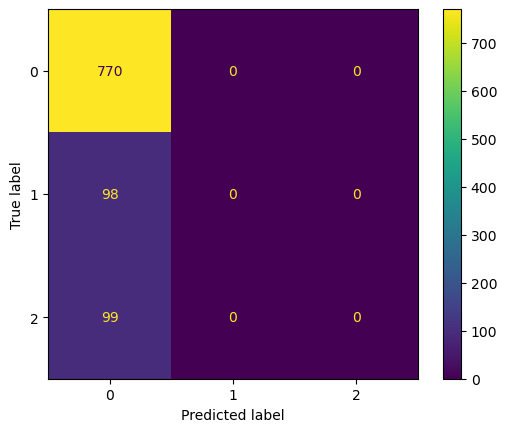

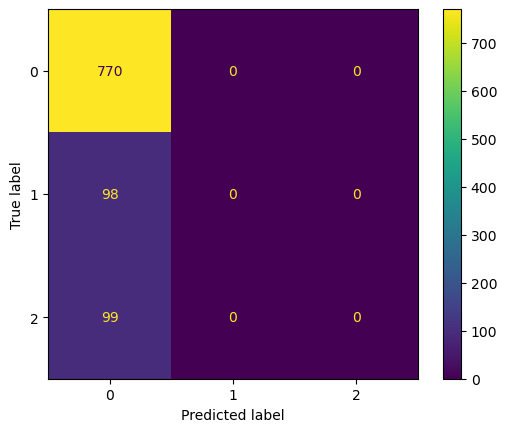

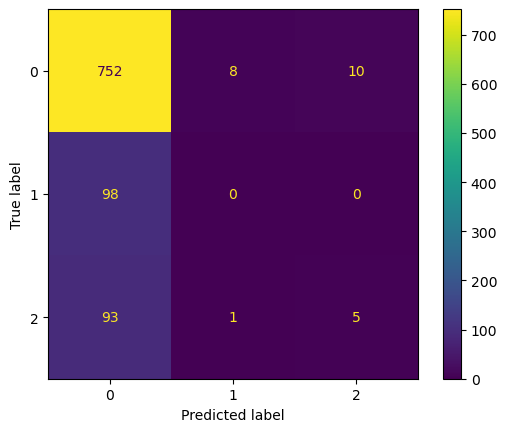

In [18]:
#main

dir_name = 'datos/'
fnames = [f for f in os.listdir(dir_name) if f.endswith('.bdf')]
random.seed(31)
random.shuffle(fnames)

split = int(0.2*len(fnames))
fval = fnames[:split]
fdata = fnames[split:]

x_train, y_train= concatenate_ventanado_etiquetado(fdata)
x_test, y_test= concatenate_ventanado_etiquetado(fval)

#x_train.plt(scalings='auto')

x_feat_train = np.log(np.var(x_train, axis=2) + 1e-12)   #(num ventanas, num canales)
x_feat_test = np.log(np.var(x_test, axis=2) + 1e-12)   #(num ventanas, num canales)

type_training=int(input("Quieres entrenar manera simple (1), manera Gonzalo (2), o manera Robert (3)? Dime: "))
models=[SVC(kernel="linear"), LinearDiscriminantAnalysis(), RandomForestClassifier(),]

if type_training==1:
    for model in models:
        model.fit(x_feat_train, y_train)
        print(model)
        print(model.score(x_feat_test , y_test))
        
        y_pred = model.predict(x_feat_test)
        cm = confusion_matrix(y_test, y_pred)
        print("Matriz de confusión:\n", cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

elif type_training==2:
    for model in models:
        clf = Pipeline([("scaler", StandardScaler()), ("ovr", OneVsRestClassifier(model))])
        clf.fit(x_feat_train, y_train)
        print(model)
        print(clf.score(x_feat_test , y_test))

        y_pred = clf.predict(x_feat_test)
        cm = confusion_matrix(y_test, y_pred)
        print("Matriz de confusión:\n", cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

elif type_training==3:
    x_flat_train, y_binary_train = tercer_tipo(x_train, y_train)
    x_flat_test, y_binary_test = tercer_tipo(x_test, y_test)

    clf_reposo = Pipeline([("scaler", StandardScaler()),("mlp", MLPClassifier(hidden_layer_sizes=(50,), max_iter=600, random_state=41))])
    clf_reposo.fit(x_flat_train, y_binary_train)
    print(clf_reposo.score(x_flat_test , y_binary_test))

    mask_nonrest_train = y_binary_train == 1
    mask_nonrest_test = y_binary_test == 1
    x_nonrest_train = x_feat_train[mask_nonrest_train]
    y_nonrest_train = y_train[mask_nonrest_train]  # 1 o 2
    x_nonrest_test = x_feat_test[mask_nonrest_test]
    y_nonrest_test = y_test[mask_nonrest_test]  # 1 o 2

    clf_mov = Pipeline([("scaler", StandardScaler()), ("svm", SVC(kernel="linear"))])
    clf_mov.fit(x_nonrest_train, y_nonrest_train)
    print(clf_mov.score(x_nonrest_test , y_nonrest_test))

    y_pred = clf_reposo.predict(x_flat_test)
    cm = confusion_matrix(y_binary_test, y_pred)
    print("Matriz de confusión:\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    
else:
    print("tendrías que haber dado 1, 2 o 3")